In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import dowhy
from dowhy import CausalModel

In [12]:
reduce_df

,hidden,g,phi,treatment,outcome
0,-0.877338,-1.224745,0,0,-5.135164
1,-0.877338,-1.224745,0,0,-7.428592
2,-0.877338,-1.224745,0,1,-5.885743
3,-0.877338,-1.224745,0,0,-3.062702
4,-0.877338,-1.224745,1,1,-4.259771
...,...,...,...,...,...
139,1.985556,1.224745,0,0,-7.166442
140,1.985556,1.224745,1,1,-4.501409
141,1.985556,1.224745,1,0,-8.194110
142,1.985556,1.224745,1,0,-6.484274


Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                               
────────────(E[outcome|phi,hidden,g])
d[treatment]                         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→outcome then P(outcome|treatment,phi,hidden,g,U) = P(outcome|treatment,phi,hidden,g)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

linear_regression
{'control_value': 0, 'treatment_value': 1, 'test_significance': True, 'evaluate_effect_strength': False, 'confidence_intervals': False, 'target_units': 'ate', 'effect_modifiers': []}


/Users/yoavger/miniconda3/envs/micra/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


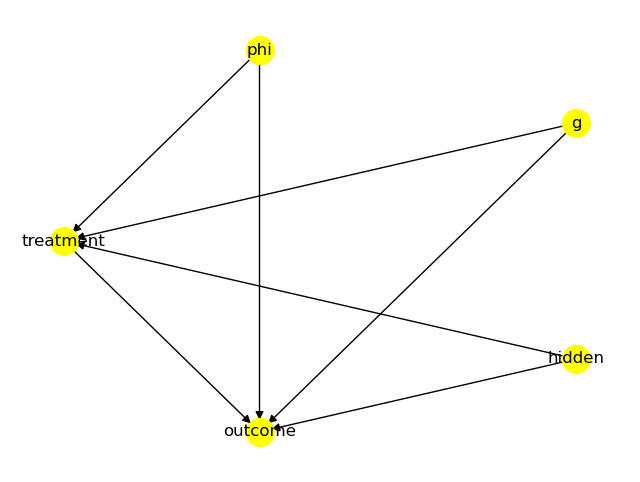

In [13]:
df = pd.read_csv('results_random_with_noise.csv') # read data 

df['phi'] = df['phi'].map({'tanh': 0, 'relu': 1}) # transfer phi to cat variable

# normalize hidden and g variable  
columns_to_normalize = ['hidden', 'g']
scaler = StandardScaler()
df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

p =  -2 +  2*df['phi'] + -1*df['g'] + 0.3*df['hidden']

# Sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

probs_for_treatment = sigmoid(p)


treatment_assignment = np.array([np.random.choice(a=[0,1],p=[1-probs_for_treatment[i],probs_for_treatment[i]]) for i in range(df.shape[0])])
outcome_based_on_treatment = np.array([df.mse_control[i] if treatment_assignment[i]==0 else df.mse_lesion_activity[i] for i in range(df.shape[0])] )
reduce_df = df[['hidden','g','phi']].copy()
reduce_df['treatment'] = treatment_assignment.astype(int)
reduce_df['outcome'] = outcome_based_on_treatment



g = """ 

digraph{
treatment;
outcome;
hidden;
g;
phi;

treatment -> outcome;

hidden -> outcome;
g -> outcome;
phi -> outcome;


hidden -> treatment;
g -> treatment;
phi -> treatment;

}


"""



model = CausalModel(
    data=reduce_df,
    treatment='treatment',
    outcome='outcome',
    graph=g
)

model.view_model()

identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

metode = 'backdoor.linear_regression' # 
deiserd_efffect = 'ate'

estimate = model.estimate_effect(identified_estimand,
                                method_name=metode,
                                target_units=deiserd_efffect,
                                 test_significance=True,
                                 # method_params={"weighting_scheme": "ips_weight"}
                                )

estimate.value

# refute_placebo_treatment = model.refute_estimate(
#     identified_estimand,  
#     estimate,  
#     method_name="placebo_treatment_refuter",  
#     placebo_type="permute" , #  method_name="random_common_cause"
#     show_progress_bar=True
# )


# Print the result of the placebo treatment refutation
# print(refute_placebo_treatment)

                            OLS Regression Results                            
Dep. Variable:            mse_control   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.393
Method:                 Least Squares   F-statistic:                     16.41
Date:                Fri, 25 Oct 2024   Prob (F-statistic):           3.47e-14
Time:                        15:36:47   Log-Likelihood:                -246.91
No. Observations:                 144   AIC:                             507.8
Df Residuals:                     137   BIC:                             528.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -6.7375      0

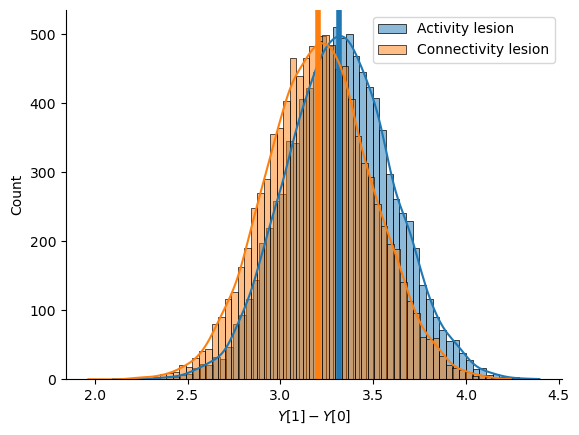

In [166]:
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('results_random_with_noise.csv')

columns_to_normalize = ['hidden', 'g']
scaler = StandardScaler()
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

model = smf.ols('mse_control ~ hidden + g + phi + task', data=data).fit()

# Output the summary of the regression model
model_summary = model.summary()
print(model_summary)

model = smf.ols('mse_lesion_activity ~ hidden + g + phi + task', data=data).fit()

# Output the summary of the regression model
model_summary = model.summary()
print(model_summary)



x = [] 
y = []
for i in range(10_000):
    t = np.random.randint(2,size=data.shape[0]).astype(bool)
    x.append(data[t].mse_lesion_activity.mean() - data[~t].mse_control.mean())
    y.append(data[t].mse_lesion_connectivity.mean() - data[~t].mse_control.mean())

sns.histplot(x,kde=True,label='Activity lesion')
plt.axvline(x=(data.mse_lesion_activity-data.mse_control).mean() ,color=sns.color_palette('tab10')[0], lw=4 )
sns.histplot(y,kde=True,label='Connectivity lesion')
plt.axvline(x=(data.mse_lesion_connectivity-data.mse_control).mean() ,color=sns.color_palette('tab10')[1], lw=4 )
sns.despine()
plt.legend()
plt.xlabel(r'$Y[1] - Y[0]$')
plt.show()

